# Auto Insurance Claims Fraud Detection - Tune & Evaluate

Following the model defintion in notebook `4-data-modeling`, next step is to train some models and tune them by exploring hyperparameter space.

## Train

Once your model is defined, it can be trained. This can happen on a single thread or on a
parallel framework like Watson Machine Learning or Apache Spark. In the most simple case
Model Definition and Model Training is just a couple of LOCs (lines of code) away. In the
case of Watson Machine Learning or Apache Spark models might need to get serialized and
transferred to another technology / framework.


## Evaluate
Evaluating models is a pivotal aspect of data science, as it directly impacts the business stakeholders' interests and the overall success of a data science project. Therefore, it merits dedicated time and attention as an independent task within the modeling process.

In supervised machine learning, evaluating models is relatively straightforward as there is always a ground truth available for comparison with the model's predictions.

Typically, we either partition the data into training, testing, and validation sets to evaluate model performance on the test set, or we employ cross-validation techniques. These concepts are elaborated upon in the following Coursera course: Advanced Machine Learning and Signal Processing (Week 2):https://www.coursera.org/learn/advanced-machine-learning-signalprocessing/.

Evaluation metrics differ between supervised learning (classification and regression), where a ground truth is available, and unsupervised learning (clustering). The choice of evaluation metrics depends on the type of model being built. Below are non-exhaustive lists that can serve as starting points for further exploration:

| Classification | Regression | Clustering |
| ---- | ---- | ---- |
| Confusion Matrix | Root Mean Squared Error (RMSE) | Adjusted Rand index |
| Accuracy | Mean Squared Error | Mutual Information |
| Precision | Mean Absolute Error (MAE) | Homogeneity completeness |
| Recall | R-Squared | V-measure |
| Specificity | Relative Squared Error | Fowlkes-Mallows |
| True positive rate | Relative Absolute Error | Silhouette Coefficient Calinski-Harabaz |
| True negative rate | Sum of Differences |  |
| False positive rate | ACF plot of residuals |  |
| False negative rate | Histogram of residuals |  |
| F1-score | Residual plots against predictors |  |
| Gain and Lift | Residual plots against fitted values |  |
| Area Under ROC | - |  |
| Gini Coefficient | - |  |
| Concordant – Discordant ratio | - |  |


[References](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

### Chosen Metric
We are dealing with binarly classification and an unbalanced dataset, so the metric I've choose to use will be `f1-score`.

## Loading dataset

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)  # Unlimited columns.
pd.options.mode.use_inf_as_na = True        # Any inf or -inf is treated as NA.

In [2]:
def to_csv(df, path):
    # Prepend dtypes to the top of df
    df2 = df.copy()
    df2.loc[-1] = df2.dtypes
    df2.index = df2.index + 1
    df2.sort_index(inplace=True)
    # Then save it to a csv
    df2.to_csv(path, index=False)
    
def read_csv(path):
    # Read types first line of csv
    dtypes = {key:value for (key,value) in pd.read_csv(path,    
              nrows=1).iloc[0].to_dict().items() if 'date' not in value}

    parse_dates = [key for (key,value) in pd.read_csv(path, 
                   nrows=1).iloc[0].to_dict().items() if 'date' in value]
    # Read the rest of the lines with the types from above
    return pd.read_csv(path, dtype=dtypes, parse_dates=parse_dates, skiprows=[1])

In [3]:
train = read_csv('data/insurance_claims_train_features.csv')
test = read_csv('data/insurance_claims_test_features.csv')

X_train = train.drop('fraud_reported', axis=1)
y_train = train['fraud_reported']
X_test =  test.drop('fraud_reported', axis=1)
y_test = test['fraud_reported']

print(f'Dataset loaded. Training set: {train.shape}. Test set: {test.shape}')
print(f'X_train {X_train.shape}, y_train {y_train.shape} \n X_test {X_test.shape}, y_test {y_test.shape}')

Dataset loaded. Training set: (699, 98). Test set: (300, 98)
X_train (699, 97), y_train (699,) 
 X_test (300, 97), y_test (300,)


## Hyperparameter tuning with Talos

With the right process in place, it will not be difficult to find state-of-the-art hyperparameter configuration for a given prediction task. Talos utilizes machine-assisted approach to finding optimal hyperparameters. 

In the following sections we'll explore how to do it and provide understaning why it works. The main priciple is simplicity.


Visualization of the [Talos Hyperparameter Tuning workflow](https://github.com/autonomio/talos).
<img src="https://camo.githubusercontent.com/53bbf546b0403bc5abdc72a3687336efacf6e15b/68747470733a2f2f692e696d6775722e636f6d2f65397662466a512e706e67" alt="drawing" width="600"/>

In [4]:
import talos
talos.__version__

Using TensorFlow backend.


'0.6.3'

### 1. Data Preparation <a name="one"></a> 
We have already cleaned and ohe variables in the dataset. Only thing remaining is exclude datetime columns and scale numerical variables.

In [5]:
X_train = X_train.select_dtypes(include='number')
X_test = X_test.select_dtypes(include='number')

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 2. Creating the Keras Model <a name="two"></a> 

Talos works with any Keras model, without changing the structure of the model in anyway, or without introducing any new syntax. The below example shows clearly how this works. 

For this example, we have to import few helper functions from Talos: 
* one for using normalized learning rate values. Including `lr_normalizer` in a model allows trying out several optimizers in a single scan, without normalization, inputting of the values would become cumbersome. 

* one for experimenting with number of hidden layers. Including `hidden_layers` in a model allows the use of number of hidden Dense layers as an optimization parameter.



In [7]:
from talos.utils import lr_normalizer
from talos.utils import hidden_layers

Note that the only difference in the model below is how instead of using a label or value to define a given model parameter, we do it using a dictionary label. Also for optimizer we are using a learning rate parameter, which involves the use of two dictionary labels.

In [28]:
from keras.models import Sequential
from keras.layers import Dropout, Dense

def fraud_detection_model(x_train, y_train, x_val, y_val, params):

    # next we can build the model exactly like we would normally do it
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation=params['activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    model.add(Dropout(params['dropout']))
    
    # if we want to also test for number of layers and shapes, that's possible
    hidden_layers(model, params, 1)
   
    # then we finish again with completely standard Keras way
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    model.compile(loss=params['losses'],
                  # here we add a regulizer normalization function from Talos
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])),
                  metrics=['acc', talos.utils.metrics.f1score])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)
    
    # finally we have to make sure that history object and model are returned
    return history, model

### 3. Defining the Parameter Space Boundary <a name="three"></a> 
In the last and final step, we're going to create the dictionary, which will then be passed on to Talos together with the model above. Here we have three different ways to input values:

- as stepped ranges (min, max, steps)
- as multiple values [in a list]
- as a single value [in a list]

For values we don't want to use, it's ok to set it as `None`.

NOTE: at this point you have to import from Keras the optimizer, activations, and losses you want to scan for.

In [9]:
from keras.optimizers import Adam, Nadam, RMSprop
from keras.activations import softmax
from keras.losses import binary_crossentropy, logcosh
from keras.activations import relu, elu, sigmoid

p = {'lr': (0.5, 5, 10),      # normalized lr, 1 represent a default value for given optimizer
     'first_neuron':[4, 8, 16, 32, 64],
     'hidden_layers':[0, 1, 2],
     'batch_size': (2, 30, 10),
     'epochs': [50, 100, 150],
     'dropout': (0, 0.5, 5),
     'kernel_initializer': ['normal'],
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'shapes': ['brick','funnel'],
     'optimizer': [Adam, Nadam, RMSprop],
     'losses': [logcosh, binary_crossentropy],
     'activation':[relu, elu],
     'last_activation': [sigmoid]}

### 4. Run the Hyperparameter <code>Scan()</code> <a name="four"></a>
Now we are ready to run the model based on the parameters and the layer configuration above. The exact same process would apply with any other model, just make sure to pass the model function name in the Scan() command as in the below example. To get started quickly, we're going to invoke the 'grid_downsample' parameter to 1/1000 of the entire permutations.

In [15]:
# and run the experiment
t = talos.Scan(x=X_train,
            y=y_train,
            model=breast_cancer_model,
            fraction_limit=0.001, 
            params=p,
            experiment_name='fraud_detection_model')

100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [1:08:57<00:00,  8.57s/it]


Because there are many permutations (540,000 in total) in this first round of the experiment, I randomly pick just 0.1% of the total, and we’re left with 540 permutations. In this case, on 2018 EliteBook with i7 CPU it takes rougly 1:20h to complete.

## 5. Analysing the Scan results with <code>Analyze()</code> <a name="five"></a> 

I’ve set up the experiment assuming no previous knowledge about optimal parameters, or the dataset. I’ve prepared the dataset by dropping one column, and by transforming all the rest so that the mean for each feature is 0, with standard deviation of 1 and encoding catagorical variables with one-hot-encoder.

After the initial run of 540 permutations, it’s time to look at the results and decide on how we’re going to limit (or otherwise alter) the parameter space.

In [10]:
# use Scan object as input
# a1 = talos.Analyze(t)
a1 = talos.Analyze('fraud_detection_model/102219065714.csv')
a1.data.head()

,round_epochs,val_loss,val_acc,val_f1score,loss,acc,f1score,activation,batch_size,dropout,emb_output_dims,epochs,first_neuron,hidden_layers,kernel_initializer,last_activation,losses,lr,optimizer,shapes,weight_regulizer
0,100,1.898967,0.757143,0.180952,0.209591,0.899796,0.367416,<function relu at 0x000002725EEA2048>,2,0.1,None,100,64,2,normal,<function sigmoid at 0x000002725EEA2158>,<function binary_crossentropy at 0x000002725EE...,2.75,<class 'keras.optimizers.RMSprop'>,funnel,None
1,50,1.814268,0.780952,0.397149,0.035392,0.981595,0.884758,<function elu at 0x000002725EE90D90>,13,0.2,None,50,16,1,normal,<function sigmoid at 0x000002725EEA2158>,<function binary_crossentropy at 0x000002725EE...,2.75,<class 'keras.optimizers.Adam'>,brick,None
2,150,0.089423,0.723810,0.000000,0.062475,0.777096,0.000000,<function relu at 0x000002725EEA2048>,16,0.4,None,150,16,1,normal,<function sigmoid at 0x000002725EEA2158>,<function logcosh at 0x000002725EE6E1E0>,3.65,<class 'keras.optimizers.Adam'>,funnel,None
3,50,0.091019,0.776190,0.541967,0.017887,0.957055,0.837897,<function elu at 0x000002725EE90D90>,16,0.0,None,50,4,2,normal,<function sigmoid at 0x000002725EEA2158>,<function logcosh at 0x000002725EE6E1E0>,3.65,<class 'keras.optimizers.RMSprop'>,funnel,None
4,150,0.078561,0.809524,0.472581,0.004565,0.987730,0.965430,<function elu at 0x000002725EE90D90>,13,0.3,None,150,32,0,normal,<function sigmoid at 0x000002725EEA2158>,<function logcosh at 0x000002725EE6E1E0>,2.30,<class 'keras.optimizers.Adam'>,brick,None


In [11]:
# get average score for a chosen metric
a1.data['val_f1score'].mean()

0.3758478995826509

In [12]:
# get the highest result for any metric
a1.high('val_f1score')

0.6771102011203766

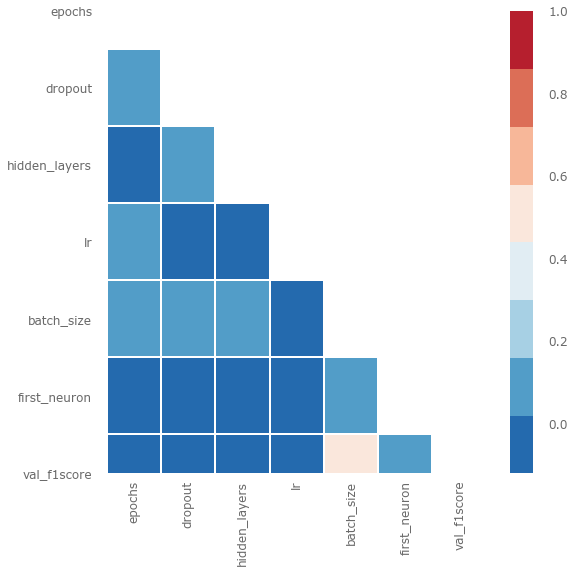

In [13]:
# heatmap correlation
a1.plot_corr('val_f1score', ['acc', 'loss', 'val_acc','f1score', 'val_loss','round_epochs'], color_grades=5)

In [14]:
a1.data[['val_f1score', 'first_neuron', 'hidden_layers', 'lr', 'epochs', 'batch_size', 'dropout']].corr()

,val_f1score,first_neuron,hidden_layers,lr,epochs,batch_size,dropout
val_f1score,1.000000,0.091159,-0.143773,0.015686,-0.000557,0.427638,-0.104881
first_neuron,0.091159,1.000000,0.016334,0.012847,-0.003152,0.050474,-0.001893
hidden_layers,-0.143773,0.016334,1.000000,-0.051446,0.019299,0.022897,0.042673
lr,0.015686,0.012847,-0.051446,1.000000,0.032371,-0.062387,0.019529
epochs,-0.000557,-0.003152,0.019299,0.032371,1.000000,0.049655,0.037182
batch_size,0.427638,0.050474,0.022897,-0.062387,0.049655,1.000000,0.080592
dropout,-0.104881,-0.001893,0.042673,0.019529,0.037182,0.080592,1.000000


A simple rank order correlation shows that batch_size has the strongest effect on our performance metric f1-score. 
* __batch_size__ is positively correlated with val_f1score
* __hidden_layers__ and __dropout__ have a small negative correlation with perfromance metric

A simpler network will do better in this taks. Let's look a little closer.

#### Batch Size

In the below graph we have batch_size on the x-axis and val_f1score on the y-axis. The trend clearly confirms correlation; higher batch_sizes do better than small ones.  

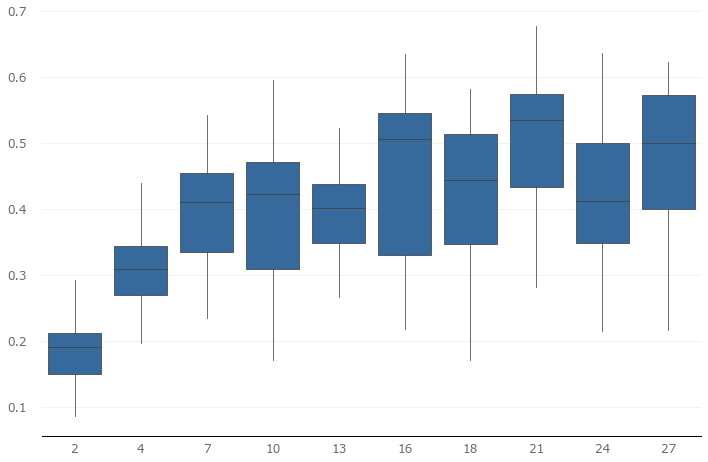

In [15]:
a1.plot_box('batch_size', 'val_f1score')

Another way to look at the batch_size is through Kernel Density Estimation. Here we can see that there is a significant tendency towards higher val_f1score with batch_size 16 and above.

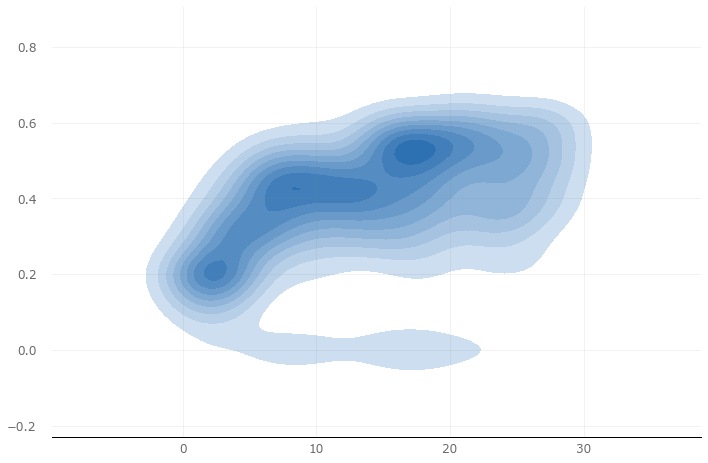

In [16]:
a1.plot_kde('batch_size', 'val_f1score')

So, for next iteration we'll remove small batch_sizes and focus on `batch_size 16-32`.

#### Epochs
In the below graph we have epochs (50, 100 and 150) on the x-axis, val_f1score on the y-axis. Because higher batch_sizes perform much better, we conider permuations with batch_size > 15. Trend signals that with number of epochs > 100 performance starts to drop.

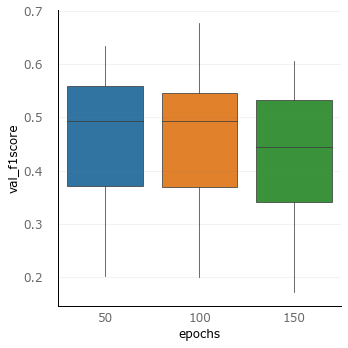

In [22]:
import seaborn as sns
sns.catplot(x='epochs', y='val_f1score', kind='box', data=a1.data.query('batch_size >= 15'));

For next round we will keep epochs as is, but remember that perfromance might decrease above 150.

#### Dropout
In the below graph we have epochs (50, 100 and 150) on the x-axis, val_f1score on the y-axis, learning rate in the columns and dropout as hue. The trend seems to be generally as the correlation suggests; __smaller dropouts do better than larger ones__.

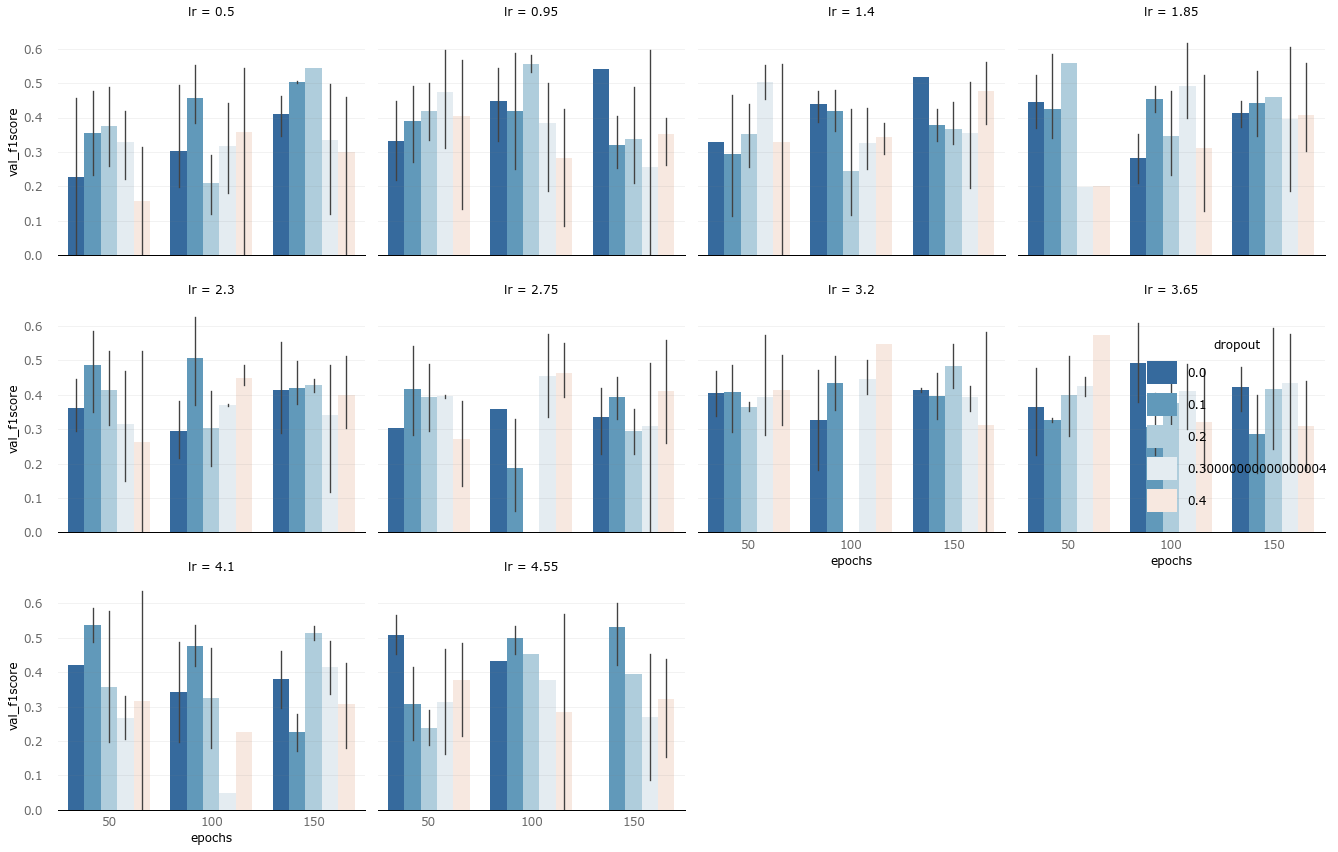

In [18]:
# a four dimensional bar grid
a1.plot_bars('epochs', 'val_f1score', 'dropout', 'lr')

Another way to look at the dropout is through Kernel Density Estimation. Here we can see that there is a slight tendency towards higher val_f1score with dropout 0 to 0.1, as well as less tendency to have low val_f1score (around the 0 mark).

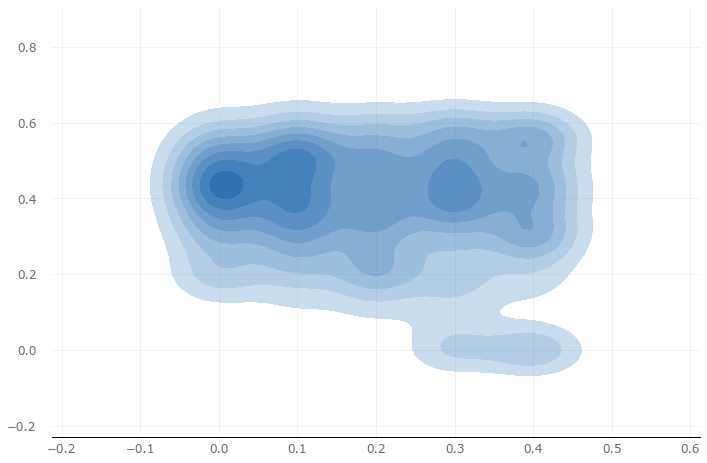

In [23]:
# up to two dimensional kernel density estimator
a1.plot_kde('dropout', 'val_f1score')

The next action item for the next round of scanning is to get rid of the higher dropout rates altogether and focus on values between `0 and 0.2`. 

#### Learning Rate
Let’s take a look at learning rate more closely next. 

Note: that learning rates are normalized across optimizers to a scale where _1 represents the Keras default value of that optimizer._

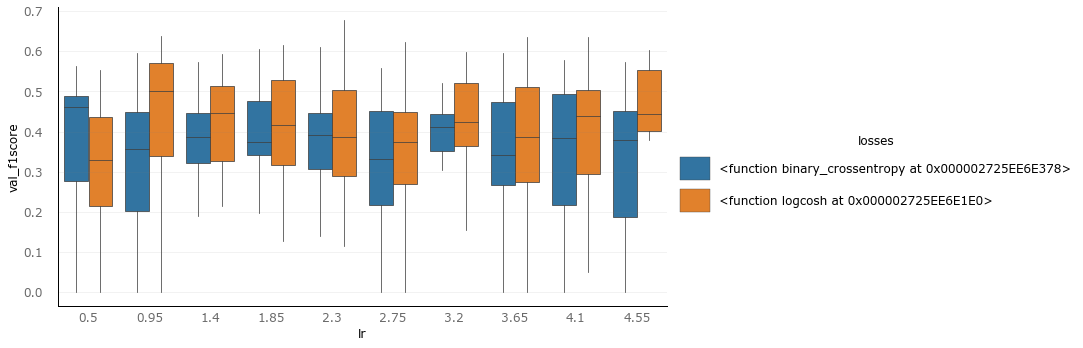

In [24]:
sns.catplot(x='lr', y='val_f1score', hue='losses', kind='box', aspect=2, data=a1.data);

The situation is mixed. Similar performance is achieved across the range, with slighlty better results with standard lr around 1 for both loss functions. Locosh is ourperforming binary_crossentropy on all but smallest lr tempting us to keep just logcosh for next iteration.

A sanity check is still needed though. 

How about if what we’re seeing is not factoring in over-fitting towards the training data? How if val_loss is all over the place and we’re just getting carried away looking at one side of the picture? A simple regression analysis show that is exaclty the case. 

We have a lot of overfitting towards training data with validation results all over the place. 

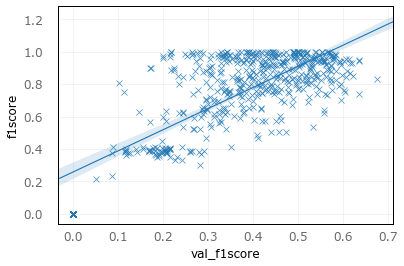

In [25]:
sns.regplot('val_f1score', 'f1score', marker='x', data=a1.data);

In [30]:
a1.data.query('(val_f1score > 0.55) & (f1score > 0.8)').describe()

,round_epochs,val_loss,val_acc,val_f1score,loss,acc,f1score,batch_size,dropout,epochs,first_neuron,hidden_layers,lr
count,55.000000,55.000000,55.000000,55.000000,5.500000e+01,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,90.000000,0.503611,0.800606,0.582377,2.708033e-02,0.971407,0.923522,21.018182,0.205455,90.000000,25.236364,0.745455,2.529091
std,40.138649,0.762959,0.010571,0.025978,4.228609e-02,0.023044,0.053809,4.335431,0.140657,40.138649,21.961215,0.821430,1.310170
min,50.000000,0.068472,0.780952,0.550521,1.042818e-07,0.907975,0.806056,10.000000,0.000000,50.000000,4.000000,0.000000,0.500000
25%,50.000000,0.075726,0.792857,0.563623,5.317206e-03,0.955010,0.881822,18.000000,0.100000,50.000000,8.000000,0.000000,1.400000
50%,100.000000,0.080516,0.800000,0.574493,1.190779e-02,0.975460,0.936873,21.000000,0.200000,100.000000,16.000000,1.000000,2.300000
75%,100.000000,0.814957,0.807143,0.595591,2.647407e-02,0.988753,0.959826,24.000000,0.300000,100.000000,32.000000,1.000000,3.650000
max,150.000000,3.044367,0.828571,0.677110,2.016099e-01,1.000000,1.000000,27.000000,0.400000,150.000000,64.000000,2.000000,4.550000


Loss and val_loss confirm the suspicion - results are all over the place.

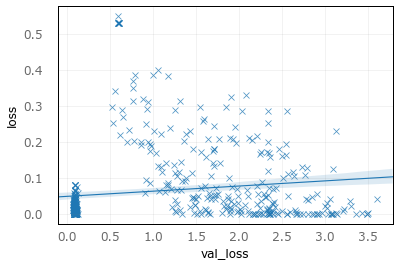

In [31]:
sns.regplot('val_loss', 'loss', marker='x', data=a1.data);

#### First Neuron (batch_size >=20)
Trend clearly shows that higher first_neuron lowers the perfomance variability accross the range. For next iteration we'll add larger numbers up to number of features (95).

Also, smaller network performs better than larger ones. For next iteration we will keep only hidden_layer [0,1] which keeps our network simpler.

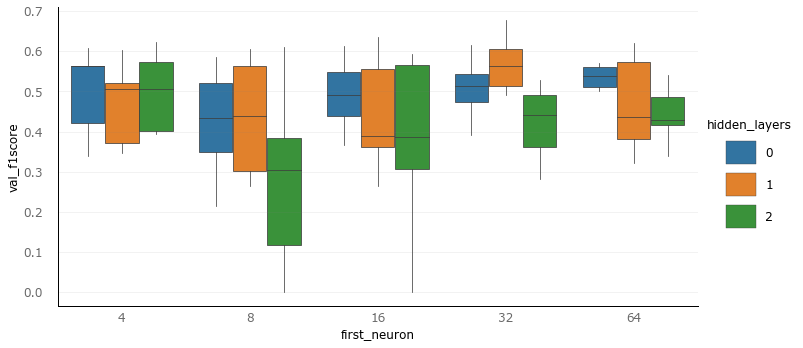

In [34]:
sns.catplot(x='first_neuron', y='val_f1score', hue='hidden_layers', kind='box', aspect=2, data=a1.data.query('batch_size >= 20'));

I think for now we know enough; it’s time to set up the next round of the experiment! As a point of reference, the parameter space for the next experiment looks like this:

In [48]:
p = {'lr': (0.8, 1.2, 3),
     'first_neuron':[32, 48, 64, 80, 96],
     'hidden_layers':[0, 1],
     'batch_size': (15, 35, 5),
     'epochs': [100, 150],
     'dropout': [0.1, 0.15, 0.2],
     'kernel_initializer': ['uniform','normal'],
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'shapes': ['brick','funnel'],
     'optimizer': [Adam, Nadam, RMSprop],
     'losses': [logcosh, binary_crossentropy],
     'activation':[relu, elu],
     'last_activation': [sigmoid]}

In [49]:
# and run the experiment
t2 = talos.Scan(x=X_train,
            y=y_train,
            model=fraud_detection_model,
            fraction_limit=0.01, 
            params=p,
            experiment_name='fraud_detection_model')


100%|████████████████████████████████████████████████████████████████████████████████| 432/432 [32:23<00:00,  4.52s/it]

## Round 2 - Increase the Focus on Result

Initially, the less we focus on the result (and more on the process), the more likely we’re going to get a good result. It’s like playing chess; if at first you’re too focused on winning the game, you will not focus on the opening and mid-game. Competitive chess is won in the endgame, based on playing a strong beginning and middle. If things go well, the second iteration in the hyperparameter optimization process is the middle. We’re not entirely focused on winning the game yet, but it helps to have the eye on the prize already. 

In our case, the results from the first round (99.1% validation f1score) indicate that with the given dataset, and the set parameter boundaries, there are predictions to be made.

In this case, the prediction task here is to say if breast cancer is benign or malignant. This type of predictions is a kind of a big deal in the sense that both false positives and false negatives do matter. Getting the prediction wrong will have some negative effect on the person’s life. In case you are interested, there is a bunch of papers written on this dataset, and some other relevant info, which you can all find here.

The result for the second round is 97.1% validation f1score which is not as good as best model from previous round.

In [50]:
a2 = talos.Analyze(t2)

In [51]:
# get the highest result for any metric
a2.high('val_f1score')

0.7197491489705585

In [61]:
a2.best_params('val_f1score', exclude=['loss', 'val_loss', 'acc', 'val_acc'])[0]

array([None, 0.1, 150, 1, 1.0666666666666667, 19,
       <function elu at 0x000001B6A1961E18>,
       <function sigmoid at 0x000001B6A19721E0>, 'uniform',
       <function logcosh at 0x000001B6A193F268>, 0.8132189455573544, None,
       80, 'funnel', <class 'keras.optimizers.Nadam'>, 150, 0],
      dtype=object)

Let's immediatelly sanity check our results for overfitting towards training data. Looks a little better. Still there are lots of overfitted models, but we see few models having balanced `f1score` and `val_f1score`. We should explore those in more detail.

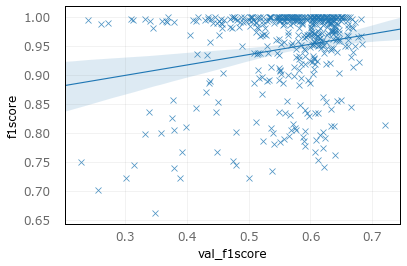

In [52]:
sns.regplot('val_f1score', 'f1score', marker='x', data=a2.data);

Let's check did we narrow down our search compared to Round 1.

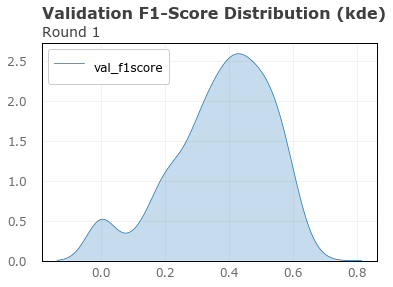

In [54]:
ax = sns.kdeplot(a1.data.val_f1score, shade=True)
ax.text(x=0.0, y=1.1, s='Validation F1-Score Distribution (kde)', fontsize=16, alpha=0.75, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
ax.text(x=0.0, y=1.02, s='Round 1', fontsize=14, alpha=0.75, ha='left', va='bottom', transform=ax.transAxes);

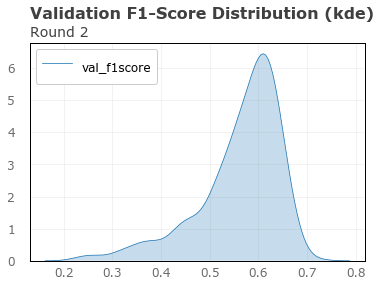

In [53]:
ax = sns.kdeplot(a2.data.val_f1score, shade=True)
ax.text(x=0.0, y=1.1, s='Validation F1-Score Distribution (kde)', fontsize=16, alpha=0.75, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
ax.text(x=0.0, y=1.02, s='Round 2', fontsize=14, alpha=0.75, ha='left', va='bottom', transform=ax.transAxes);

The second round KDE looks much better in the sense of having the resources allocated where we need them to be. They are closer to 0.6 on the x-axis, and there is very little in terms of “spillage” towards the 0. Whatever compute resources are going into the scan, they’re are doing important work. The ideal picture here is one of a single straight line with the x value of 1.

#### Zooming in
The below correlation shows what the only sting sticking out at this point, is the __hidden_layers__ with negative correlation to performance metric.

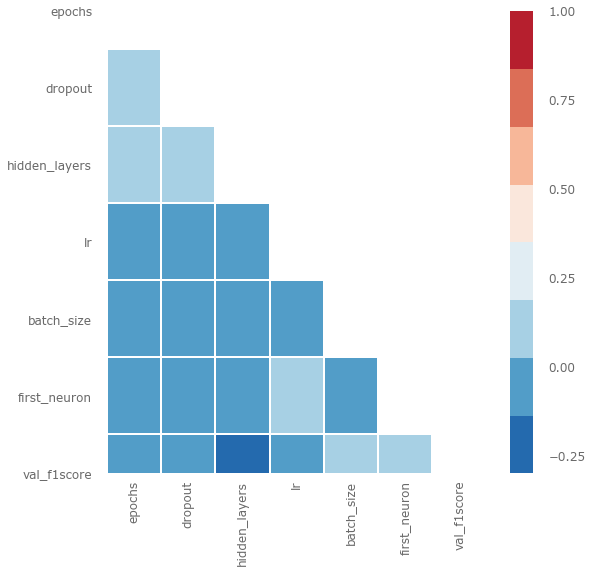

In [62]:
a2.plot_corr('val_f1score', ['acc', 'loss', 'val_acc','f1score', 'val_loss','round_epochs'], color_grades=5)

#### Network complexity
Below graph has number first layer neurons on x-axis, val_f1score on y-axis and hidden_layers as hue. We observe that simpler network outperforms larger networks across the range. That is same observation as we had in Round 1. For next iteration we'll __remove hidden_layer__ from the model.

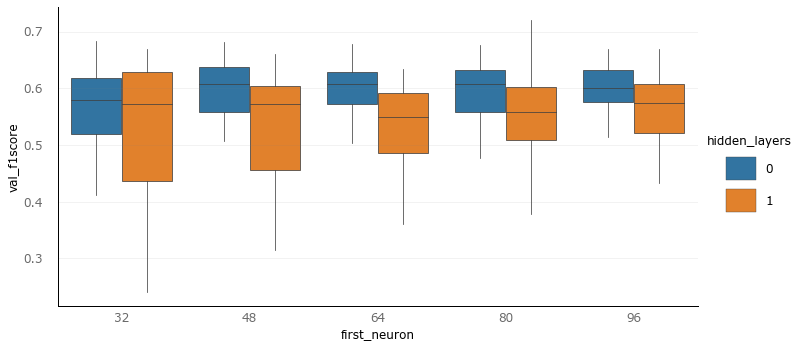

In [63]:
sns.catplot(x='first_neuron', y='val_f1score', hue='hidden_layers', kind='box', aspect=2, data=a2.data);

In [93]:
a2_hl0 = a2.data.query('hidden_layers == 0')

#### Learning rate
When looking at learning rate in single layer networks, we observe performance metric does not vary much with changing lr. 
Also we observe that here is less performance variabilty with higher number of neurons.

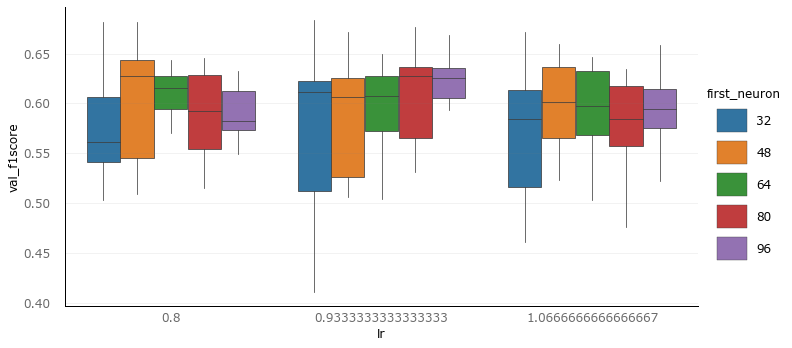

In [102]:
sns.catplot(x='lr', y='val_f1score', hue='first_neuron', kind='box', aspect=2, data=a2_hl0);

#### Dropout
In the below graph we have epochs (100 and 150) on the x-axis, val_acc on the y-axis, size of first_layer in the columns and dropout as hue. We observe following:
* more `epochs` perform better. Next iteration add `[150,250]`
* `dropout` paramteres 0.1 and 0.15 have consistenlty better results than 0.2

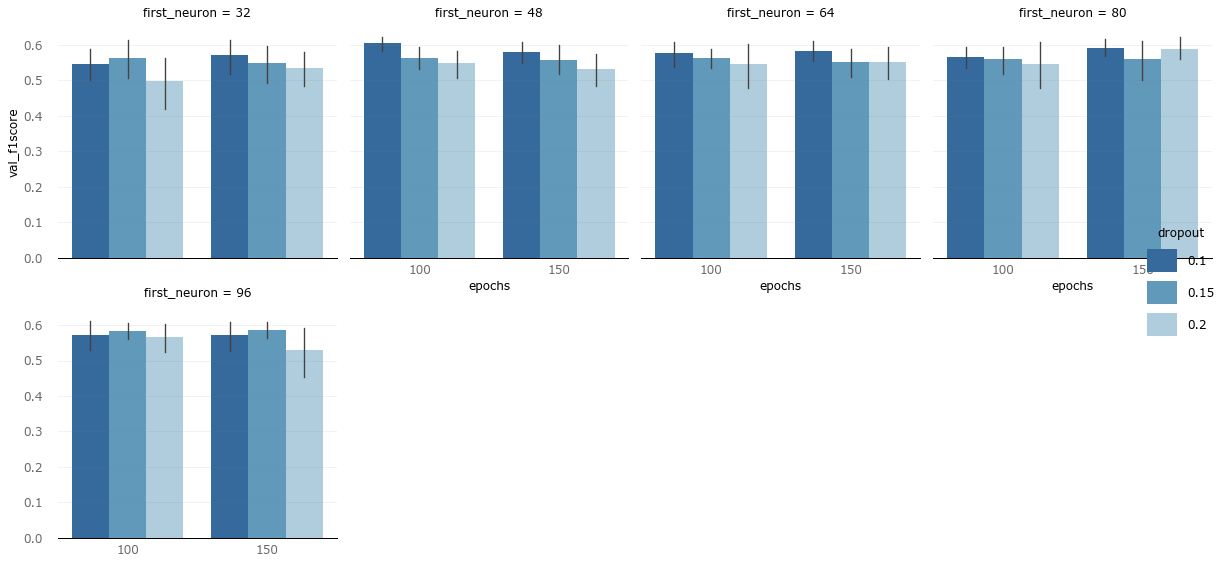

In [96]:
# a four dimensional bar grid
a2.plot_bars('epochs', 'val_f1score', 'dropout', 'first_neuron')

#### Optimizers
Now that we’ve eliminated the logcosh loss function, and have just one loss (binary_crossentropy) in the parameter space, I want to learn a little bit about __how the different optimizers are performing in the context of the epochs__.

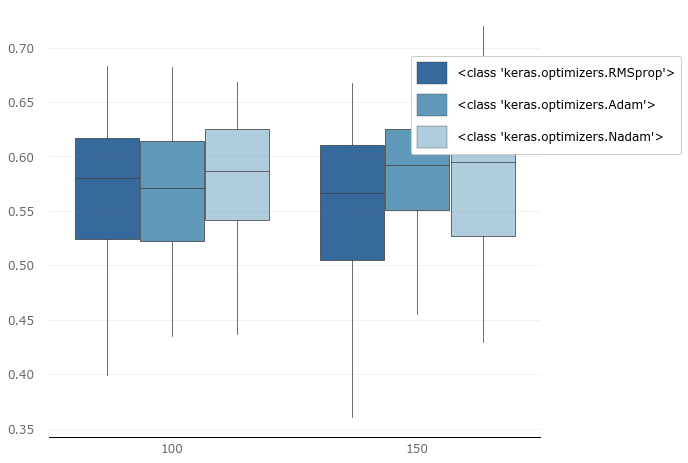

In [98]:
a2.plot_box('epochs', 'val_f1score', hue='optimizer')

It is exactly like the correlation suggests regarding epochs (now on the x-axis). Because __RMSprop__ underperforms in both 100 and 150, let’s also __drop__ that from the next round.

## Round 3 - Generalization and Performance
### 3.1 - Simpler model

In [106]:
p = {'lr': (1, 2, 5),
     'first_neuron':[48, 64, 80, 96],
     'hidden_layers':[0],
     'batch_size': (15, 35, 5),
     'epochs': [150, 200, 250],
     'dropout': [0.1, 0.15],
     'kernel_initializer': ['uniform','normal'],
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'shapes': [None],
     'optimizer': [Adam, Nadam],
     'losses': [logcosh, binary_crossentropy],
     'activation':[relu, elu],
     'last_activation': [sigmoid]}

In [108]:
# and run the experiment
t3 = talos.Scan(x=X_train,
            y=y_train,
            model=fraud_detection_model,
            fraction_limit=0.2, 
            params=p,
            experiment_name='fraud_detection_model')




  0%|                                                                                          | 0/384 [00:00<?, ?it/s]


  0%|▏                                                                                 | 1/384 [00:04<28:24,  4.45s/it]


  1%|▍                                                                                 | 2/384 [00:08<27:59,  4.40s/it]


  1%|▋                                                                                 | 3/384 [00:16<34:19,  5.41s/it]


  1%|▊                                                                                 | 4/384 [00:20<30:51,  4.87s/it]


  1%|█                                                                                 | 5/384 [00:23<27:46,  4.40s/it]


  2%|█▎                                                                                | 6/384 [00:28<29:49,  4.74s/it]


  2%|█▍                                                                                | 7/384 [00:34<30:51,  4.91s/it]


  2%|█▋              

In [9]:
# a3 = talos.Analyze(t3) # 102319074232.csv
a3 = talos.Analyze('fraud_detection_model/102319074232.csv')

In [9]:
e3 = talos.Evaluate(t3)
p3 = talos.Predict(t3)
talos.Deploy(t3, 'round3-best', metric='val_f1score')

In [10]:
# get the highest result for any metric
a3.high('val_f1score')

0.7005450346640179

In [70]:
a3.best_params('val_f1score', exclude=['loss', 'val_loss', 'acc', 'val_acc'])[0]

array(['None', 200, "<class 'keras.optimizers.Adam'>",
       '<function sigmoid at 0x000001B6A19721E0>', 0.1, 200,
       0.9812020710640891, 27, 48, 1, 0, 'uniform', 'None',
       '<function elu at 0x000001B6A1961E18>', 'None',
       '<function logcosh at 0x000001B6A193F268>', 0], dtype=object)

Let's immediatelly sanity check our results for overfitting towards training data. Looks a little better. Still there are lots of overfitted models with val_f1score variying signifficantly, but we see more models that perform close to `val_f1score` 0.7. We should explore those in more detail.

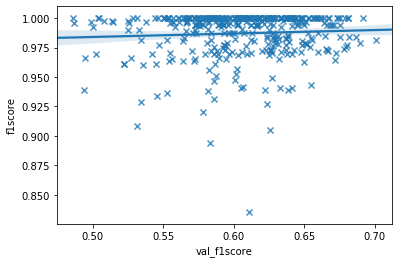

In [14]:
sns.regplot('val_f1score', 'f1score', marker='x', data=a3.data);

Narowing down parameter search area, improved focus on higher performing models, with least performing model is above 0.45.

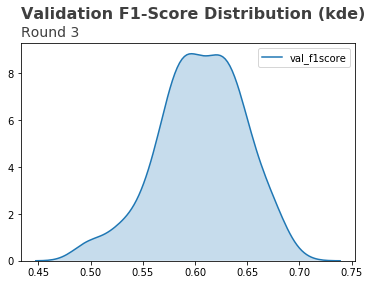

In [15]:
ax = sns.kdeplot(a3.data.val_f1score, shade=True)
ax.text(x=0.0, y=1.1, s='Validation F1-Score Distribution (kde)', fontsize=16, alpha=0.75, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
ax.text(x=0.0, y=1.02, s='Round 3', fontsize=14, alpha=0.75, ha='left', va='bottom', transform=ax.transAxes);

We confirm that batch_size has highest positive correlation with the score. For some reason all permutations we done with `lr=1`, so we need to keep this in mind and fix it for the next round.

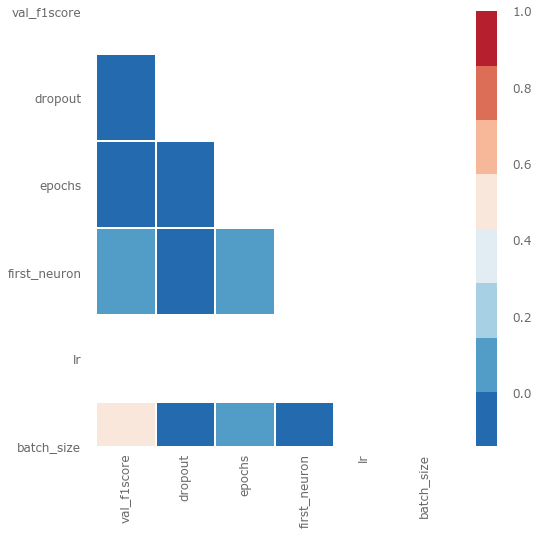

In [22]:
# heatmap correlation
a3.plot_corr('val_f1score', ['acc', 'loss', 'val_acc','f1score', 'val_loss','round_epochs', 'hidden_layers'], color_grades=5)

#### Batch Size
Above 20 performs consistently better.

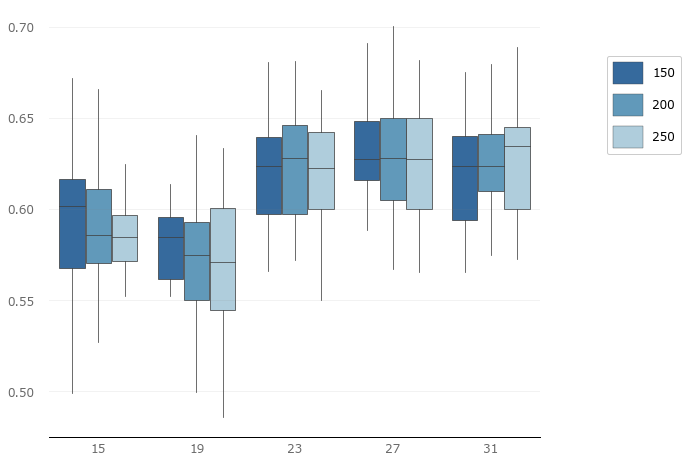

In [27]:
a3.plot_box('batch_size', 'val_f1score', hue='epochs')

#### Optimizer
Adam performs slightly better.

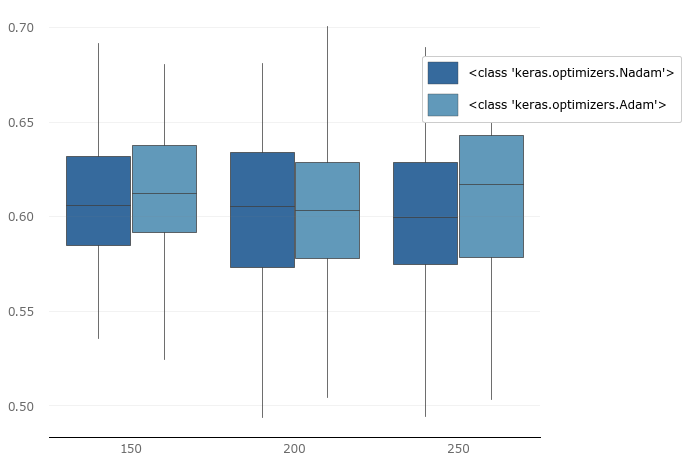

In [31]:
a3.plot_box('epochs', 'val_f1score', hue='optimizer')

#### Dropout
In the below graph we have epochs on the x-axis, val_acc on the y-axis, size of first_layer in the columns and dropout as hue. We observe that smaller dropout has capability to reach higher score accross the range.

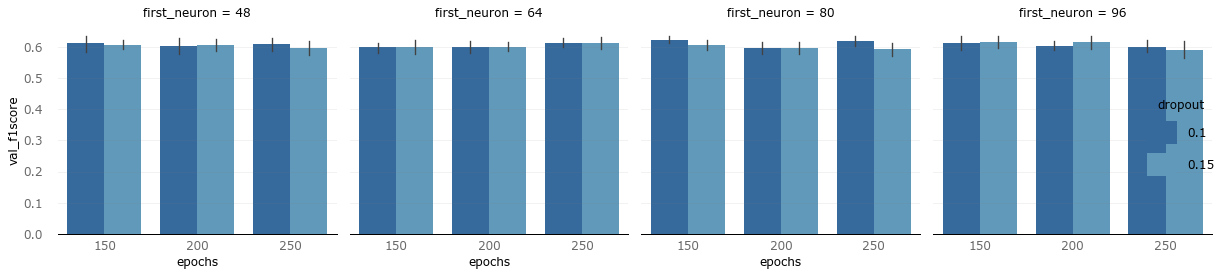

In [57]:
# a four dimensional bar grid
a3.plot_bars('epochs', 'val_f1score', 'dropout', 'first_neuron')

In [72]:
(a3.data
 .query('val_loss < 0.5')
 .groupby(['dropout', 'first_neuron'])['val_f1score']
 .max().sort_values(ascending=False)
 .head(10)
)

dropout  first_neuron
0.10     48              0.700545
0.15     48              0.689311
0.10     64              0.681707
0.15     80              0.680556
         96              0.679608
         64              0.675617
0.10     96              0.659960
         80              0.654819
Name: val_f1score, dtype: float64

As it was discussed in the foreword, it’s important to consider generalization as well. Every time we look at the result, there is the effect where our insights start to affect the experiment. The net result is that we start to get less generalized models that work well with the validation dataset, but might not work well with a “real-life” dataset. In this case, we don’t have a good way to test for this kind of bias, but at least we can take measures to assess the degree of pseudo-generalization with what we have. Let’s see training and validation f1_score first.

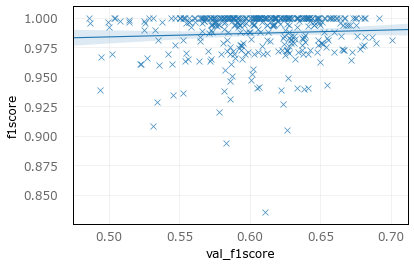

In [50]:
sns.regplot('val_f1score', 'f1score', marker='x', data=a3.data);

Even though this does not give us an affirmative confirmation of having a well-generalized model, in fact, it falls short from it a great deal; the regression analysis shows difficulty for our model to break past 0.7 val_f1score.  

Then looking at loss, we see two groups of models: 1 that didn't overfit and 1 the did with the high val_loss. Earlystopping can be used to prevent this.

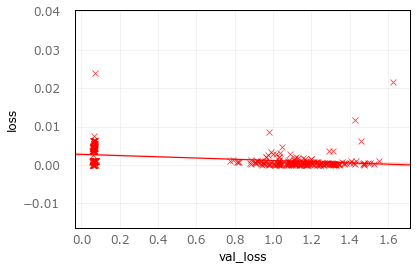

In [51]:
sns.regplot('val_loss', 'loss', marker='x', color='red', data=a3.data);

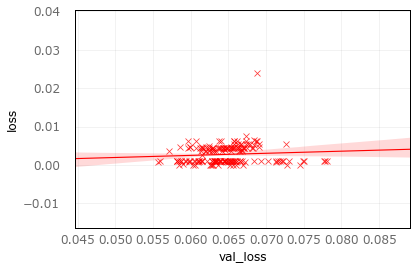

In [46]:
sns.regplot('val_loss', 'loss', marker='x', color='red', data=a3.data.query('val_loss < 0.5'));

Before diving into the next round, let’s look at one more visualization from the results of the last round. This time 5-dimensional. I wanted to see the remaining parameters — kernel initializer, batch size, first neuron, and epochs — all in the same picture compared against loss.

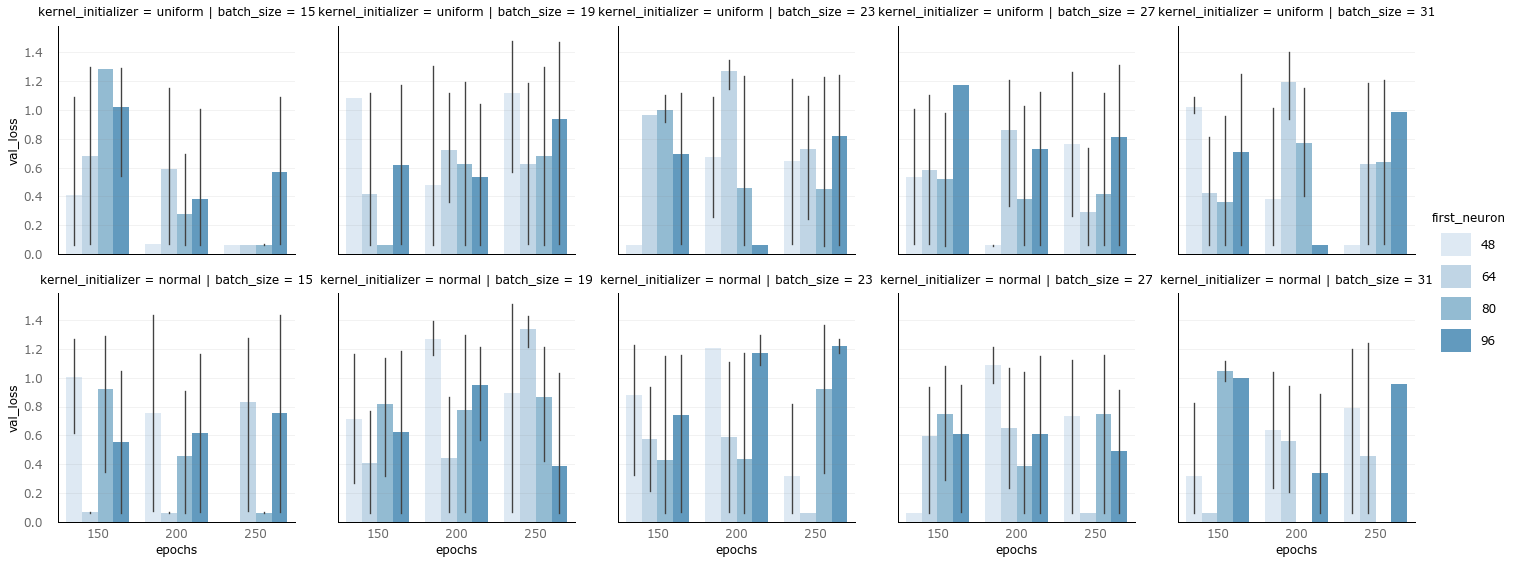

In [74]:
sns.factorplot(data=a3.data,
               x='epochs',
               y='val_loss',
               hue='first_neuron',               
               row='kernel_initializer',
               col='batch_size',
               palette=sns.color_palette("Blues"),
               legend=True,
               legend_out=True,
               size=4,
               kind='bar');

We see loss is all over the place. 

### Full Run
Let's try to limit number of permutation by being smart when choosing them and let the experiment run in full. Total of 6400 permutations with estimated time of 10 hours is reduced by 50% by using correlation to smartly choose best performing parameters. Best performing model has training f1score 0.89 (0.03), and f1score on unseen data of __0.62 (0.06)__

In [32]:
p = {'lr': [0.8, 1, 1.2, 1.5, 2],
     'first_neuron':[48, 64, 80, 96],
     'batch_size': (15, 35, 5),
     'epochs': [200, 250],
     'hidden_layers':[0],
     'shapes': [None],
     'dropout': [0.1, 0.2],
     'kernel_initializer': ['uniform','normal'],
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'optimizer': [Adam, Nadam],
     'losses': [logcosh, binary_crossentropy],
     'activation':[relu, elu],
     'last_activation': [sigmoid]}

In [33]:
# and run the experiment
t5 = talos.Scan(x=X_train,
            y=y_train,
            model=fraud_detection_model, 
            params=p,
            experiment_name='fraud_detection_model',
            reduction_method='correlation',
            reduction_interval=50,
            reduction_window=25,
            reduction_threshold=0.2,
            reduction_metric='val_f1score',
            minimize_loss=False)




  0%|                                                                                         | 0/6400 [00:00<?, ?it/s]


  0%|                                                                              | 1/6400 [00:05<10:05:22,  5.68s/it]


  0%|                                                                              | 2/6400 [00:11<10:14:02,  5.76s/it]


  0%|                                                                              | 3/6400 [00:18<10:39:21,  6.00s/it]


  0%|                                                                              | 4/6400 [00:25<11:34:33,  6.52s/it]


  0%|                                                                              | 5/6400 [00:33<12:18:54,  6.93s/it]


  0%|                                                                              | 6/6400 [00:41<12:42:52,  7.16s/it]


  0%|                                                                              | 7/6400 [00:48<12:36:17,  7.10s/it]


  0%|                

Total 24.8% permutations reduced





 26%|███████████████████▋                                                        | 1660/6400 [12:40<7:18:43,  5.55s/it]


 26%|███████████████████▋                                                        | 1661/6400 [12:40<7:01:21,  5.33s/it]


 26%|███████████████████▋                                                        | 1662/6400 [12:47<7:44:41,  5.88s/it]


 26%|███████████████████▋                                                        | 1663/6400 [12:55<8:22:00,  6.36s/it]


 26%|███████████████████▊                                                        | 1664/6400 [13:02<8:42:03,  6.61s/it]


 26%|███████████████████▊                                                        | 1665/6400 [13:09<8:48:58,  6.70s/it]


 26%|███████████████████▊                                                        | 1666/6400 [13:16<8:58:54,  6.83s/it]


 26%|███████████████████▊                                                        | 1667/6400 [13:24<9:18:33,  7.08s/it]


 26%|████████████████

Total 20.0% permutations reduced





 43%|████████████████████████████████▉                                           | 2769/6400 [39:50<5:15:19,  5.21s/it]


 43%|████████████████████████████████▉                                           | 2770/6400 [39:55<5:13:04,  5.17s/it]


 43%|████████████████████████████████▉                                           | 2771/6400 [40:02<5:37:43,  5.58s/it]


 43%|████████████████████████████████▉                                           | 2772/6400 [40:08<5:57:14,  5.91s/it]


 43%|████████████████████████████████▉                                           | 2773/6400 [40:15<6:03:04,  6.01s/it]


 43%|████████████████████████████████▉                                           | 2774/6400 [40:22<6:23:27,  6.35s/it]


 43%|████████████████████████████████▉                                           | 2775/6400 [40:28<6:24:43,  6.37s/it]


 43%|████████████████████████████████▉                                           | 2776/6400 [40:35<6:26:02,  6.39s/it]


 43%|████████████████

Total 50.0% permutations reduced





 72%|██████████████████████████████████████████████████████▋                     | 4610/6400 [45:40<2:33:44,  5.15s/it]


 72%|██████████████████████████████████████████████████████▊                     | 4611/6400 [45:41<2:28:14,  4.97s/it]


 72%|██████████████████████████████████████████████████████▊                     | 4612/6400 [45:48<2:46:11,  5.58s/it]


 72%|██████████████████████████████████████████████████████▊                     | 4613/6400 [45:55<2:57:18,  5.95s/it]


 72%|██████████████████████████████████████████████████████▊                     | 4614/6400 [46:02<3:06:45,  6.27s/it]


 72%|██████████████████████████████████████████████████████▊                     | 4615/6400 [46:09<3:11:09,  6.43s/it]


 72%|██████████████████████████████████████████████████████▊                     | 4616/6400 [46:16<3:15:53,  6.59s/it]


 72%|██████████████████████████████████████████████████████▊                     | 4617/6400 [46:24<3:25:34,  6.92s/it]


 72%|████████████████

Total 25.0% permutations reduced





 80%|████████████████████████████████████████████████████████████▌               | 5096/6400 [52:24<2:01:57,  5.61s/it]


 80%|████████████████████████████████████████████████████████████▌               | 5097/6400 [52:40<2:01:52,  5.61s/it]


 80%|████████████████████████████████████████████████████████████▌               | 5098/6400 [52:42<2:21:28,  6.52s/it]


 80%|████████████████████████████████████████████████████████████▌               | 5099/6400 [52:51<2:37:59,  7.29s/it]


 80%|████████████████████████████████████████████████████████████▌               | 5100/6400 [53:00<2:52:51,  7.98s/it]


 80%|████████████████████████████████████████████████████████████▌               | 5101/6400 [53:10<3:00:14,  8.32s/it]


 80%|████████████████████████████████████████████████████████████▌               | 5102/6400 [53:19<3:09:12,  8.75s/it]


 80%|████████████████████████████████████████████████████████████▌               | 5103/6400 [53:30<3:20:41,  9.28s/it]


 80%|████████████████

Total 33.5% permutations reduced





 87%|██████████████████████████████████████████████████████████████████          | 5566/6400 [57:59<1:08:28,  4.93s/it]


 87%|██████████████████████████████████████████████████████████████████          | 5567/6400 [58:10<1:08:23,  4.93s/it]


 87%|██████████████████████████████████████████████████████████████████          | 5568/6400 [58:18<1:27:43,  6.33s/it]


 87%|██████████████████████████████████████████████████████████████████▏         | 5569/6400 [58:29<1:47:45,  7.78s/it]


 87%|██████████████████████████████████████████████████████████████████▏         | 5570/6400 [58:38<1:52:15,  8.11s/it]


 87%|██████████████████████████████████████████████████████████████████▏         | 5571/6400 [58:46<1:52:35,  8.15s/it]


 87%|██████████████████████████████████████████████████████████████████▏         | 5572/6400 [58:55<1:54:01,  8.26s/it]


 87%|██████████████████████████████████████████████████████████████████▏         | 5573/6400 [59:02<1:52:21,  8.15s/it]


 87%|████████████████

Total 49.6% permutations reduced





 94%|███████████████████████████████████████████████████████████████████████▎    | 6005/6400 [1:03:51<29:03,  4.41s/it]


 94%|███████████████████████████████████████████████████████████████████████▎    | 6007/6400 [1:04:05<34:05,  5.20s/it]


 94%|███████████████████████████████████████████████████████████████████████▎    | 6008/6400 [1:04:12<37:24,  5.73s/it]


 94%|███████████████████████████████████████████████████████████████████████▎    | 6009/6400 [1:04:19<39:31,  6.07s/it]


 94%|███████████████████████████████████████████████████████████████████████▎    | 6010/6400 [1:04:27<41:55,  6.45s/it]


 94%|███████████████████████████████████████████████████████████████████████▍    | 6011/6400 [1:04:34<44:23,  6.85s/it]


 94%|███████████████████████████████████████████████████████████████████████▍    | 6012/6400 [1:04:42<46:15,  7.15s/it]


 94%|███████████████████████████████████████████████████████████████████████▍    | 6013/6400 [1:04:50<47:01,  7.29s/it]


 94%|████████████████

Total 48.8% permutations reduced





 98%|██████████████████████████████████████████████████████████████████████████▌ | 6275/6400 [1:17:20<06:30,  3.12s/it]


 98%|██████████████████████████████████████████████████████████████████████████▌ | 6276/6400 [1:17:26<07:51,  3.80s/it]


 98%|██████████████████████████████████████████████████████████████████████████▌ | 6277/6400 [1:17:31<08:35,  4.19s/it]


 98%|██████████████████████████████████████████████████████████████████████████▌ | 6278/6400 [1:17:36<09:06,  4.48s/it]


 98%|██████████████████████████████████████████████████████████████████████████▌ | 6279/6400 [1:17:41<09:28,  4.70s/it]


 98%|██████████████████████████████████████████████████████████████████████████▌ | 6280/6400 [1:17:47<09:45,  4.88s/it]


 98%|██████████████████████████████████████████████████████████████████████████▌ | 6281/6400 [1:17:55<11:45,  5.92s/it]


 98%|██████████████████████████████████████████████████████████████████████████▌ | 6282/6400 [1:18:03<13:03,  6.64s/it]


 98%|████████████████

We see nice progress towards and even beyond 0.7 f1score.

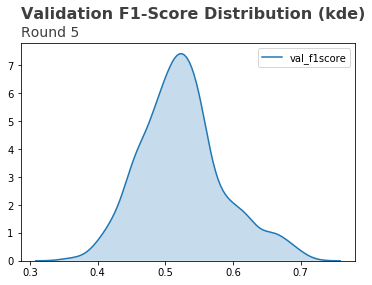

In [80]:
ax = sns.kdeplot(a5.data.val_f1score, shade=True)
ax.text(x=0.0, y=1.1, s='Validation F1-Score Distribution (kde)', fontsize=16, alpha=0.75, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
ax.text(x=0.0, y=1.02, s='Round 5', fontsize=14, alpha=0.75, ha='left', va='bottom', transform=ax.transAxes);

#### Analyze the results

In [34]:
a5 = talos.Analyze(t5)

In [43]:
# get the highest result for any metric
a5.high('val_f1score')

0.7143269584292458

In [36]:
e5 = talos.Evaluate(t5)
e5.evaluate(X_train, y_train, task='binary', metric='val_f1score', print_out=True)

mean : 0.89 
 std : 0.03


[0.8787878787878788,
 0.9310344827586207,
 0.918918918918919,
 0.9032258064516129,
 0.8405797101449276]

#### Evaluate models with unseen data

In [66]:
t5.evaluate_models(X_test, y_test, 'binary', n_models=20, metric='val_f1score')




  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


  5%|████▏                                                                              | 1/20 [00:00<00:03,  5.80it/s]


 10%|████████▎                                                                          | 2/20 [00:00<00:03,  5.75it/s]


 15%|████████████▍                                                                      | 3/20 [00:00<00:02,  5.82it/s]


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  5.83it/s]


 25%|████████████████████▊                                                              | 5/20 [00:00<00:02,  5.80it/s]


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:02,  5.76it/s]


 35%|█████████████████████████████                                                      | 7/20 [00:01<00:02,  5.69it/s]


 40%|████████████████

>> Added evaluation score columns to scan_object.data


AttributeError: 'NoneType' object has no attribute 'sort_index'

In [72]:
t5.data.dropna(subset=['eval_f1score_mean'], axis=0).sort_values('eval_f1score_mean', ascending=False).iloc[0:3,:]

,round_epochs,val_loss,val_acc,val_f1score,loss,acc,f1score,activation,batch_size,dropout,emb_output_dims,epochs,first_neuron,hidden_layers,kernel_initializer,last_activation,losses,lr,optimizer,shapes,weight_regulizer,eval_f1score_mean,eval_f1score_std
708,250,0.050650,0.871429,0.672221,0.011536,0.973415,0.900867,<function elu at 0x000001BD33E1DA60>,23,0.1,None,250,80,0,uniform,<function sigmoid at 0x000001BD33E1DD90>,<function logcosh at 0x000001BD33DE3E18>,1.5,<class 'keras.optimizers.Nadam'>,None,None,0.620818,0.066122
763,250,0.054127,0.871429,0.699467,0.008038,0.981595,0.964410,<function elu at 0x000001BD33E1DA60>,31,0.2,None,250,80,0,uniform,<function sigmoid at 0x000001BD33E1DD90>,<function logcosh at 0x000001BD33DE3E18>,1.0,<class 'keras.optimizers.Adam'>,None,None,0.616286,0.091773
751,250,0.053626,0.871429,0.699681,0.008917,0.979550,0.949797,<function elu at 0x000001BD33E1DA60>,31,0.1,None,250,80,0,uniform,<function sigmoid at 0x000001BD33E1DD90>,<function logcosh at 0x000001BD33DE3E18>,1.0,<class 'keras.optimizers.Adam'>,None,None,0.609628,0.117552


In [73]:
talos.Deploy(t5, 'round5-best', metric='eval_f1score_mean')

Deploy package round5-best have been saved.


In [78]:
a5.best_params('eval_f1score_mean', exclude=['f1score','loss', 'val_loss', 'acc', 'val_acc'])[0]

array([23, 0.1, 0, 1.5, <class 'keras.optimizers.Nadam'>, None, None,
       0.6722210500921522, 250, 80,
       <function sigmoid at 0x000001BD33E1DD90>, None,
       <function logcosh at 0x000001BD33DE3E18>, 0.06612195505775505, 250,
       'uniform', <function elu at 0x000001BD33E1DA60>, 0], dtype=object)

In [79]:
a5.data.sort_values('eval_f1score_mean', ascending=False).iloc[0,7:]

activation                <function elu at 0x000001BD33E1DA60>
batch_size                                                  23
dropout                                                    0.1
emb_output_dims                                           None
epochs                                                     250
first_neuron                                                80
hidden_layers                                                0
kernel_initializer                                     uniform
last_activation       <function sigmoid at 0x000001BD33E1DD90>
losses                <function logcosh at 0x000001BD33DE3E18>
lr                                                         1.5
optimizer                     <class 'keras.optimizers.Nadam'>
shapes                                                    None
weight_regulizer                                          None
eval_f1score_mean                                     0.620818
eval_f1score_std                                      0

## Making Predcitions

In [81]:
p5 = talos.Predict(t5, task='binary')
y_pred = p5.predict(X_test, model_id=708)

In [82]:
preds = (y_pred > 0.5).astype(int)

In [84]:
from sklearn.metrics import classification_report, f1_score
print(f1_score(y_test, preds))

0.6329113924050633


In [85]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       220
           1       0.64      0.62      0.63        80

   micro avg       0.81      0.81      0.81       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.81      0.81      0.81       300



In [92]:
restore = talos.Restore('round5-best.zip')
model = restore.model

In [98]:
y_pred = model.predict(X_test)
preds = (y_pred > 0.5).astype(int)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, preds))

[[192  28]
 [ 30  50]]


In [99]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, preds)

0.7488636363636364

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics

def plot_roc(y_test, y_pred):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    f, ax = plt.subplots(figsize=(5, 5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

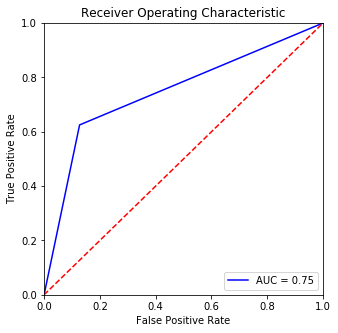

In [101]:
plot_roc(y_test, preds)